In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import sys
import time
import tensorflow as tf
import keras.applications.xception as xception
import tensorflow.keras as keras
import re
import cv2
from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras import applications
from keras.applications.inception_v3 import InceptionV3


Defining constant

In [151]:
rootdir= 'D:/APU/FYP/Program/garbage_classification/' #path of the original folder

IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

classes = {0:'battery',1: 'biological',2: 'brown-glass',
3:'cardboard',4: 'green-glass',
 5:'metal',6: 'paper',7: 'plastic',
 8: 'trash',9:'white-glass'}


Create Dataframe

In [152]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

filenames_list = []
categories_list = []

for category in classes:
    filenames = os.listdir(rootdir + classes[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})
df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  8213


In [153]:
df

,filename,category
0,paper/paper422.jpg,6
1,paper/paper133.jpg,6
2,white-glass/white-glass710.jpg,9
3,battery/battery333.jpg,0
4,metal/metal510.jpg,5
...,...,...
8208,white-glass/white-glass261.jpg,9
8209,trash/trash616.jpg,8
8210,paper/paper372.jpg,6
8211,biological/biological512.jpg,1


brown-glass/brown-glass181.jpg


c:\Users\User\anaconda3\lib\site-packages\keras\utils\image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


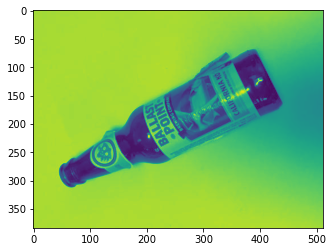

In [154]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = keras.utils.load_img(rootdir +sample['filename'],(320,320))
print(sample['filename'])
plt.imshow(randomimage)

Visualize the Categories Distribution

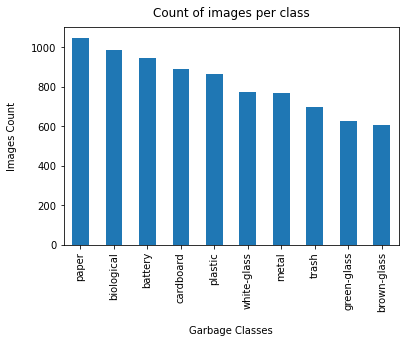

In [155]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:classes[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

Model

In [156]:

def get_model():
  pre_trained_model =InceptionV3(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS) #Shape of the images
  ,include_top=False #Leave out the last fully connected layer
  ,weights="imagenet")

  for layer in pre_trained_model.layers:
      layer.trainable =False
  
  x=Sequential()

  x.add(keras.Input(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
  def xception_preprocessing(img):
    return xception.preprocess_input(img)

  x.add(Lambda(xception_preprocessing))
  x.add(pre_trained_model)
  x.add(GlobalAveragePooling2D())
  x.add(Dropout(0.2))
  x.add(Dense(10,activation =tf.nn.softmax))

  model = x
  model.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model
              

In [157]:
model=get_model()

Save model

In [158]:
%pwd

'D:\\APU\\Yahya course\\tensorflow-yolov4-tflite'

In [160]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 320, 320, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_______________________________________

Dataset Split

In [161]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(classes) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test=test_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', total_test)

train size =  6570 validate size =  821 test size =  822


In [162]:
train_df

,filename,category
0,battery/battery138.jpg,battery
1,brown-glass/brown-glass555.jpg,brown-glass
2,battery/battery451.jpg,battery
3,cardboard/cardboard318.jpg,cardboard
4,battery/battery344.jpg,battery
...,...,...
6565,paper/paper802.jpg,paper
6566,white-glass/white-glass200.jpg,white-glass
6567,cardboard/cardboard444.jpg,cardboard
6568,green-glass/green-glass466.jpg,green-glass


Train model

In [165]:

Batch_Size=64
#Add data augmentation
train_datagen=ImageDataGenerator(###,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,zoom_range=0.3,horizontal_flip=True,vertical_flip = True###)
)

#flow training data
train_generator=train_datagen.flow_from_dataframe(train_df,rootdir,x_col='filename',y_col='category',
 class_mode='categorical',batch_size=Batch_Size,target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),seed=42)

#ADD validation data augmentation
validation_datagen=ImageDataGenerator()

validation_generator=validation_datagen.flow_from_dataframe(validate_df,rootdir,x_col='filename',y_col='category',
 class_mode='categorical',batch_size=Batch_Size,target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),seed=42)

Found 6570 validated image filenames belonging to 10 classes.
Found 821 validated image filenames belonging to 10 classes.


In [16]:
file_path="D:/APU/FYP/Program/garbage_classification/weights.best.f1"
checkpoint = ModelCheckpoint(file_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="accuracy", mode="max", patience=2)
callbacks_list = [checkpoint, early]



In [28]:
history=model.fit(train_generator,validation_data=validation_generator,steps_per_epoch=total_train//Batch_Size,epochs=20,validation_steps=total_validate//Batch_Size,callbacks=callbacks_list)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.8292 
Epoch 1: accuracy did not improve from 0.95881
102/102 [==============================] - 1194s 12s/step - loss: 0.5687 - accuracy: 0.8292 - val_loss: 0.4044 - val_accuracy: 0.8984
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.8727 
Epoch 2: accuracy did not improve from 0.95881
102/102 [==============================] - 1191s 12s/step - loss: 0.4321 - accuracy: 0.8727 - val_loss: 0.3298 - val_accuracy: 0.9180
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8860 
Epoch 3: accuracy did not improve from 0.95881
102/102 [==============================] - 1182s 12s/step - loss: 0.3816 - accuracy: 0.8860 - val_loss: 0.3024 - val_accuracy: 0.9180
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8929 
Epoch 4: accuracy did not improve from 0.95881
102/102 [=============

In [29]:
model.save_weights(file_path)

Evaluate model


In [252]:
model.load_weights(file_path)


NameError: name 'model' is not defined

In [18]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=rootdir,
    x_col='filename',
    y_col='category',
    target_size=(320,320),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 822 validated image filenames belonging to 10 classes.


In [19]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

C:\Users\User\AppData\Local\Temp/ipykernel_14340/79043940.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  96.72 % 


Plotting the accuracy


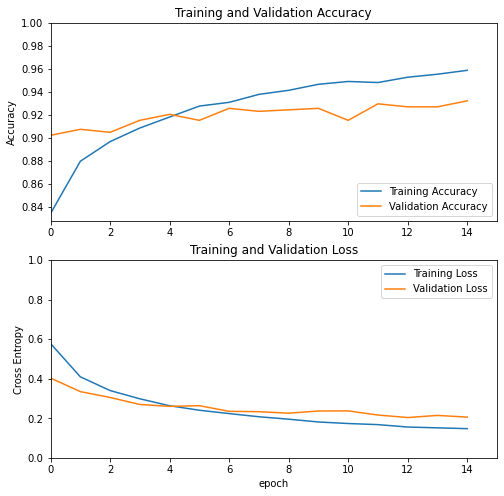

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([0,15.0])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlim([0,15.0])
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'green-glass', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'trash', 9: 'white-glass'}


In [21]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

C:\Users\User\AppData\Local\Temp/ipykernel_14340/727984934.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.99      0.99      0.99       106
  biological       1.00      1.00      1.00        92
 brown-glass       0.93      0.89      0.91        61
   cardboard       1.00      1.00      1.00        91
 green-glass       0.91      0.94      0.92        63
       metal       0.94      0.95      0.95        85
       paper       0.98      0.99      0.99       109
     plastic       0.95      0.95      0.95        81
       trash       1.00      1.00      1.00        57
 white-glass       0.93      0.92      0.93        77

    accuracy                           0.97       822
   macro avg       0.96      0.96      0.96       822
weighted avg       0.97      0.97      0.97       822



YOLOV4

In [ ]:
%pip install yolov4

Changing all the dataset into one category which is trash and not trashes


In [25]:
folders = 'D:/APU/FYP/Program/garbage/'
count = 1
# count increase by 1 in each iteration
# iterate all files from a directory
for file_name in os.listdir(folders):
    # Construct old file name
    source = folders + file_name

    # Adding the count to the new file name and extension
    destination = folders + "trash_" + str(count) + ".jpg"

    # Renaming the file
    os.rename(source, destination)
    count += 1
print('All Files Renamed')



All Files Renamed


In [12]:
folderss = 'D:/APU/FYP/Program/garbage/Non trash/'
count = 1
# count increase by 1 in each iteration
# iterate all files from a directory
for file_name in os.listdir(folderss):
    # Construct old file name
    source = folderss + file_name

    # Adding the count to the new file name and extension
    destination = folderss + "Not_trash_" + str(count) + ".jpg"

    # Renaming the file
    os.rename(source, destination)
    count += 1
print('All Files Renamed')

All Files Renamed


Transfering Yolo To Yolo Tensorflow version

In [1]:
#!git clone https://github.com/theAIGuysCode/tensorflow-yolov4-tflite.git

Cloning into 'tensorflow-yolov4-tflite'...


In [6]:
%cd D:\APU\Yahya course\tensorflow-yolov4-tflite

D:\APU\Yahya course\tensorflow-yolov4-tflite


In [ ]:
%pip install -r requirements.txt

Converting the Yolo with weight that has been trained on Google Collab

In [9]:
!python save_model.py --weights ./data/yolov4custom.weights --output ./checkpoints/yolov4-416 --input_size 416 --model yolov4 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 416, 416, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

2022-06-25 17:20:02.670071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudnn64_8.dll'; dlerror: cudnn64_8.dll not found
2022-06-25 17:20:02.670402: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-25 17:20:02.671385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0625 17:20:06.510215 16784 saving_utils.py:328] Compiled the loaded model, but the compile

 conv2d_3 (Conv2D)              (None, 208, 208, 64  4096        ['tf.math.multiply_1[0][0]']     
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 208, 208, 64  256        ['conv2d_3[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 tf.math.softplus_3 (TFOpLambda  (None, 208, 208, 64  0          ['batch_normalization_3[0][0]']  
 )                              )                                                                 
                                                                                                  
 tf.math.tanh_3 (TFOpLambda)    (None, 208, 208, 64  0           ['tf.math.softplus_3[0][0]']     
          


                                                                                                  
 tf.math.tanh_30 (TFOpLambda)   (None, 52, 52, 128)  0           ['tf.math.softplus_30[0][0]']    
                                                                                                  
 tf.math.multiply_30 (TFOpLambd  (None, 52, 52, 128)  0          ['batch_normalization_30[0][0]', 
 a)                                                               'tf.math.tanh_30[0][0]']        
                                                                                                  
 conv2d_31 (Conv2D)             (None, 52, 52, 128)  147456      ['tf.math.multiply_30[0][0]']    
                                                                                                  
 batch_normalization_31 (BatchN  (None, 52, 52, 128)  512        ['conv2d_31[0][0]']              
 ormalization)                                                                                    
         

Predicting image using the custom model

In [2]:
#load model
%cd D:/APU/Yahya course/tensorflow-yolov4-tflite
reconstructed_model = keras.models.load_model("my_model")
reconstructed_model.load_weights("my_model/weights.best.f1")

D:\APU\Yahya course\tensorflow-yolov4-tflite


In [3]:
import re
import numpy as np

def bbox_preprocess(crop_image_coor):
    split1=re.sub("[\n\r[]","",crop_image_coor)
    split2=split1.split("]")
    res = [ele for ele in split2 if ele.strip()]

    csv=[]
    for i in res:
        split3=i.split(',')
        csv.append(split3)

    csv2=[]
    for i in csv:
        for j in i:
            j=float(j)
            csv2.append(int(j))


    arr=np.array([csv2],int).reshape(int(len(csv2)/4),4)
    return arr


In [4]:
import subprocess

def yolov4_predict(path):
    %cd D:/APU/Yahya course/tensorflow-yolov4-tflite
    detect1=subprocess.run("python detect.py --weights ./checkpoints/yolov4-416 --size 416 --model yolov4 --images {} --crop".format(path),shell=True ,stderr=subprocess.DEVNULL,stdout=subprocess.PIPE)
  
    return detect1.stdout.decode()


In [5]:
def image_resize(img_path,obj_name):
    image = Image.open(img_path + obj_name)
    if image.size == (320,320):
        print("Image is in correct shape")
        spliting= obj_name
    else:
        image = image.resize((320, 320), Image.ANTIALIAS)
        spliting=lambda x:x.split("/")
        spliting=spliting(obj_name)[-1]
        image.save(img_path+spliting)
    return spliting

In [37]:

paths= "./data/images/"
obj_names="Not_trash_2.jpg"
image_paths=image_resize(paths,obj_names)
New_image_paths=paths+image_paths



Image is in correct shape


In [38]:
New_image_paths

'./data/images/Not_trash_2.jpg'

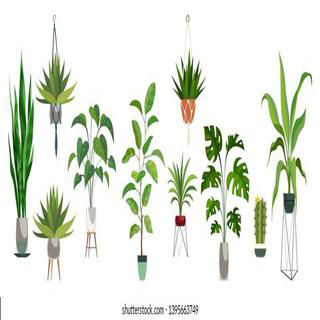

In [39]:
images = Image.open(New_image_paths)
images


In [40]:
c_image=yolov4_predict(New_image_paths)

D:\APU\Yahya course\tensorflow-yolov4-tflite


In [41]:
c_image

'[]\r\n'

In [42]:
coordinate=bbox_preprocess(c_image)

In [44]:
len(coordinate)

0

Cropped Image

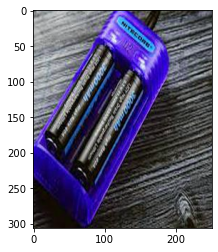

In [11]:
img=cv2.imread(New_image_paths)
import os

for file in os.listdir(paths+"predict/"):
    os.remove(paths+"predict/"+file)
for index,i in enumerate(coordinate):
    #x = i[0],y=i[1],w=i[2],h=i[3]
    cropped_image = img[i[1]:i[1]+i[3], i[0]:i[0]+i[2]]
    plt.imshow(cropped_image)
    full_path=paths+"predict/cropped_"+str(index)+".jpg"
    cv2.imwrite(full_path, cropped_image)
    








Inceptionv3 predicting


In [56]:
def inceptionv3_predict():
    test_idg = ImageDataGenerator()
    test_gen = test_idg.flow_from_directory(
        "./data/images/",
        target_size=(320,320),
        color_mode="rgb",
        class_mode="categorical",
        batch_size=1,
        shuffle=False 
    )

    gen_label_map = {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'green-glass', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'trash', 9: 'white-glass'}
    nb_samples = len(gen_label_map)
    pred=reconstructed_model.predict_generator(test_gen,nb_samples)
    pred=pred.argmax(1)

    preds = [gen_label_map[item] for item in pred]
    return preds


Interface

In [1]:
import tkinter as tk
from tkinter import *
from tkinter import ttk
from PIL import ImageTk
import PIL.Image
from tkinter.filedialog import askopenfile
import re
import numpy as np
import subprocess
import os
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import sys
import time
import tensorflow as tf
import keras.applications.xception as xception
import tensorflow.keras as keras
import re
import cv2
from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras import applications
from keras.applications.inception_v3 import InceptionV3
#load model
%cd D:/APU/Yahya course/tensorflow-yolov4-tflite
reconstructed_model = keras.models.load_model("my_model")
reconstructed_model.load_weights("my_model/weights.best.f1")

D:\APU\Yahya course\tensorflow-yolov4-tflite


In [2]:
def bbox_preprocess(crop_image_coor):
    split1=re.sub("[\n\r[]","",crop_image_coor)
    split2=split1.split("]")
    res = [ele for ele in split2 if ele.strip()]

    csv=[]
    for i in res:
        split3=i.split(',')
        csv.append(split3)

    csv2=[]
    for i in csv:
        for j in i:
            if(j !=''):
                j=j.strip()
                j=float(j)
                csv2.append(int(j))


    arr=np.array([csv2],int).reshape(int(len(csv2)/4),4)
    return arr



def yolov4_predict(path):
    %cd D:/APU/Yahya course/tensorflow-yolov4-tflite #change this directory to where the tensorflow-yolov4-tflite file are
    detect1=subprocess.run("python detect.py --weights ./checkpoints/yolov4-416 --size 416 --model yolov4 --images {} --crop".format(path),shell=True ,stderr=subprocess.DEVNULL,stdout=subprocess.PIPE)
  
    return detect1.stdout.decode()

def image_resize(img_path,obj_name):
    image = Image.open(img_path + obj_name)
    if image.size == (320,320):
        print("Image is in correct shape")
        spliting= obj_name
    else:
        image = image.resize((320, 320), Image.ANTIALIAS)
        spliting=lambda x:x.split("/")
        spliting=spliting(obj_name)[-1]
        image.save(img_path+spliting)
    return spliting

def inceptionv3_predict():
    test_idg = ImageDataGenerator()
    test_gen = test_idg.flow_from_directory(
        "./data/images/",
        target_size=(320,320),
        color_mode="rgb",
        class_mode="categorical",
        batch_size=1,
        shuffle=False 
    )

    gen_label_map = {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard'
    , 4: 'green-glass', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'trash', 9: 'white-glass'}
    nb_samples = len(gen_label_map)
    pred=reconstructed_model.predict_generator(test_gen,nb_samples)
    pred=pred.argmax(1)

    preds = [gen_label_map[item] for item in pred]
    return preds

def crop(new_img_path,paths,coordinates):
    img=cv2.imread(new_img_path)
    for file in os.listdir(paths+"predict/"):
        os.remove(paths+"predict/"+file)
    for index,i in enumerate(coordinates):
        #x = i[0],y=i[1],w=i[2],h=i[3]
        cropped_image = img[i[1]:i[1]+i[3], i[0]:i[0]+i[2]]
        full_path=paths+"predict/cropped_"+str(index)+".jpg"
        cv2.imwrite(full_path, cropped_image)
    

In [7]:
root=tk.Tk()
canvas=tk.Canvas(root,width=300,height=200)
canvas.grid(columnspan=3,rowspan=3)

#instruction
instruction=tk.Label(root,text="Select One of the two choices")
instruction.grid(column=1,row=0)

def open_game_win():
    game_win=Toplevel(root)
    game_win.geometry("1000x700")
    game_win.title("Minigame")
    image_1=PIL.Image.open('D:\\APU\\Yahya course\\tensorflow-yolov4-tflite\\data\\Logo\\1.png')
    image_1=image_1.resize((300,300),Image.ANTIALIAS)
    image1=ImageTk.PhotoImage(image_1)
    image_2=PIL.Image.open('D:\\APU\\Yahya course\\tensorflow-yolov4-tflite\\data\\Logo\\2.png')
    image_2=image_2.resize((300,300),Image.ANTIALIAS)
    image2=ImageTk.PhotoImage(image_2)
    image_3=PIL.Image.open('D:\\APU\\Yahya course\\tensorflow-yolov4-tflite\\data\\Logo\\3.jpg')
    image_3=image_3.resize((300,300),Image.ANTIALIAS)
    image3=ImageTk.PhotoImage(image_3)
    labela=Label(game_win,text="Question 1",font=('Arial',30))
    labela.place(x=200,y=15)
    labela1=Label(game_win,text="Guess is the picture recyclable (Only correct answer to proceed)",font=('Arial',20))
    labela1.place(x=50,y=55)
    labela2=Label(game_win,image=image1)
    labela2.image=image1
    labela2.place(x=300,y=100)
    buttona1=Button(game_win,text="recyclable",command=lambda:q2(labela,labela2,buttona1,buttona2,labela1),font=('Arial',30))
    buttona1.place(x=250,y=450)
    buttona2=Button(game_win,text="non-recyclable",font=('Arial',30))
    buttona2.place(x=550,y=450)
    def q2(labela,labela2,buttona1,buttona2,labela1):
        labela.destroy()
        labela2.destroy()
        buttona1.destroy()
        buttona2.destroy()
        labela=Label(game_win,text="Question 2",font=('Arial',30))
        labela.place(x=200,y=15)
        labela2=Label(game_win,image=image2)
        labela2.image=image2
        labela2.place(x=300,y=100)
        buttona1=Button(game_win,text="recyclable",font=('Arial',30))
        buttona1.place(x=250,y=450)
        buttona2=Button(game_win,text="non-recyclable",command=lambda:q3(labela,labela2,buttona1,buttona2,labela1),font=('Arial',30))
        buttona2.place(x=550,y=450)

        def q3(labela,labela2,buttona1,buttona2,labela1):
            labela.destroy()
            labela2.destroy()
            buttona1.destroy()
            buttona2.destroy()
            labela=Label(game_win,text="Question 3",font=('Arial',30))
            labela.place(x=200,y=15)
            labela2=Label(game_win,image=image3)
            labela2.image=image3
            labela2.place(x=300,y=100)
            buttona1=Button(game_win,text="recyclable",font=('Arial',30))
            buttona1.place(x=250,y=450)
            buttona2=Button(game_win,text="non-recyclable",command=lambda:finish(labela,labela2,buttona1,buttona2,labela1),font=('Arial',30))
            buttona2.place(x=550,y=450)

            def finish(labela,labela2,buttona1,buttona2,labela1):
                labela.destroy()
                labela2.destroy()
                buttona1.destroy()
                buttona2.destroy()
                labela1.destroy()
                labela=Label(game_win,text="Congrats you have completed the minigame",font=('Arial',15))
                labela.place(x=200,y=15)
                buttona1=Button(game_win,text="Quit",command=lambda:w_quit(game_win),font=('Arial',30))
                buttona1.place(x=450,y=450)

                def w_quit(root):
                    root.destroy()












    





def open_detection_win():
   new= Toplevel(root)
   new.geometry("1000x500")
   new.title("Waste Detection")
   #browse button
   browse_text=tk.StringVar()
   browse_btn=tk.Button(new,textvariable=browse_text,command=lambda:open_pic_file(browse_text,new),bg="#20bebe",fg="white").pack(side=TOP)
   browse_text.set("Browse and Detect Image")
   
   
   #Label
   Label(new,text=" List Of Recyclable \n 1.Plastic \n 2.Aluminium \n 3.Glasses \n 4.Cardboard \n 5.Metal \n 6.Newspaper \n 7.Glass \nNon-Recyclable \n 1.Electronic \n 2.Styrofoam \n 3.Ceramics \n 4.Food ").pack(side=RIGHT)
   

def detect(img_paths):
    path= "./data/images/"
    obj_names=img_paths
    image_paths=image_resize(path,obj_names)
    New_image_paths=path+image_paths
    c_image=yolov4_predict(New_image_paths)
    coordinate=bbox_preprocess(c_image)

    if(len(coordinate) != 0):
        
        crop(New_image_paths,path,coordinate)
        prediction=inceptionv3_predict()
    else:
        prediction=['Not Trash']
    return prediction

    
   
def open_pic_file(btn,roots):
    btn.set("Loading...")

    file=askopenfile(parent=roots,initialdir="./data/images/",mode="rb",title="Choose an image",filetypes=[("JPG File","*.jpg")])
    if file:
        
        # Create an object of tkinter ImageTk
        image=PIL.Image.open(file)
        image=image.resize((300,300),Image.ANTIALIAS)
        img = ImageTk.PhotoImage(image)
        myvar=Label(roots,image = img)
        
        myvar.image = img
        myvar.pack()
        btn.set("Browse Image")
        splitting=lambda x:x.split("/")
        img_paths=splitting(file.name)[-1]
        prediction=detect(img_paths)
        print(prediction)
        if(len(prediction)==1):
            prediction_label=Label(roots,text="This is predicted outcome "+prediction[0]).pack(side=BOTTOM)
        else:
            for i in prediction:
                prediction_label=Label(roots,text="This is predicted outcome "+i).pack(side=BOTTOM)
        
    else:
        btn.set("Browse Image")
        prediction="Nothing to be predicted"
    return prediction


#button1
page_refer_text=tk.StringVar()
page_refer_btn=tk.Button(root,textvariable=page_refer_text,command=lambda:open_detection_win(),bg="#20bebe",fg="white")
page_refer_text.set("Waste Detection")
page_refer_btn.grid(column=1,row=1)

#button2
page_refer_text2=tk.StringVar()
page_refer_btn2=tk.Button(root,textvariable=page_refer_text2,command=lambda:open_game_win(),bg="#20bebe",fg="white")
page_refer_text2.set("Minigame")
page_refer_btn2.grid(column=1,row=2)



root.mainloop()